In [1]:
#import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# supress error
pd.options.mode.chained_assignment = None

# load data

In [2]:
# importing data and reading data from csv file
# entries do have whitespace at before chars --> remove them with skipinitialspace
data = pd.read_csv('data/adult.csv', header = None, skipinitialspace=True)
# name columns
data.columns = ['age', 'workclass', "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income" ]
# show dataset
data.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


# describe dataset

In [3]:
# 32561 rows, 15 columns
data.shape

(32561, 15)

In [4]:
# Check for Null Data
data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [5]:
# dataset has no NaNs but a lot of ?
data.select_dtypes(object).apply(lambda x: x.str.contains('?', regex=False)).sum()

workclass         1836
education            0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
native_country     583
income               0
dtype: int64

In [6]:
# replace ? with Nans
data = data.replace('?', np.NaN )

In [7]:
# Check for again for null data
data.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

In [8]:
# Get data types
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

In [9]:
# show all duplicated entries of the dataset
print('Duplicated entries:',data.duplicated().sum())
# # check if duplicated entries are NaN --> is not the case DELETE?
# data[data.duplicated()].isna().mean()

Duplicated entries: 24


In [10]:
# remove 24 duplicates
data = data.drop_duplicates()
print('Duplicated entries: ', data.duplicated().sum())

Duplicated entries:  0


## visualization

<AxesSubplot:xlabel='income', ylabel='count'>

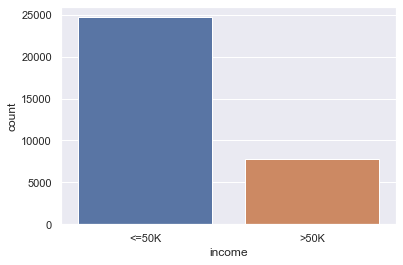

In [11]:
# Count of >50K & <=50K
sns.set_theme(style="darkgrid")
sns.countplot(x="income", data=data)

<AxesSubplot:xlabel='sex', ylabel='count'>

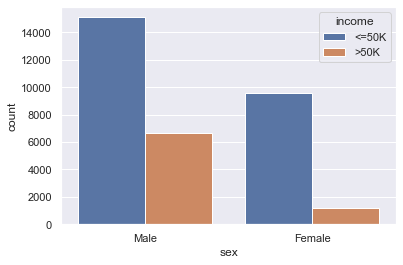

In [12]:
#difference male and female
sns.countplot(x="sex", hue='income', data=data)

In [13]:
# Alter wird hier durch Young, Adult und Old ersetzt --> macht das Sinn? Zahlen passen doch auch, oder? @Tina
# data_vis = data;
# data_vis['age'] = pd.cut(data_vis['age'], bins = [0, 25, 50, 100], labels = ['Young', 'Adult', 'Old'])
# sns.countplot(x = 'income', hue = 'age', data = data_vis)

<AxesSubplot:xlabel='education_num', ylabel='count'>

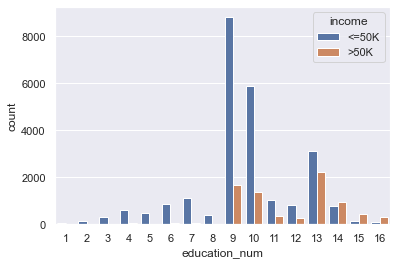

In [14]:
# income in correlation with education years
sns.countplot(x = 'education_num', hue = 'income', data = data)

<AxesSubplot:xlabel='income', ylabel='count'>

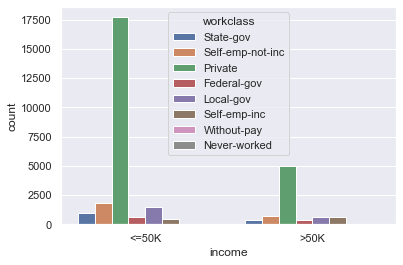

In [15]:
#Plotting workclass corresponding to the income
sns.countplot(x = 'income', hue = 'workclass', data = data)

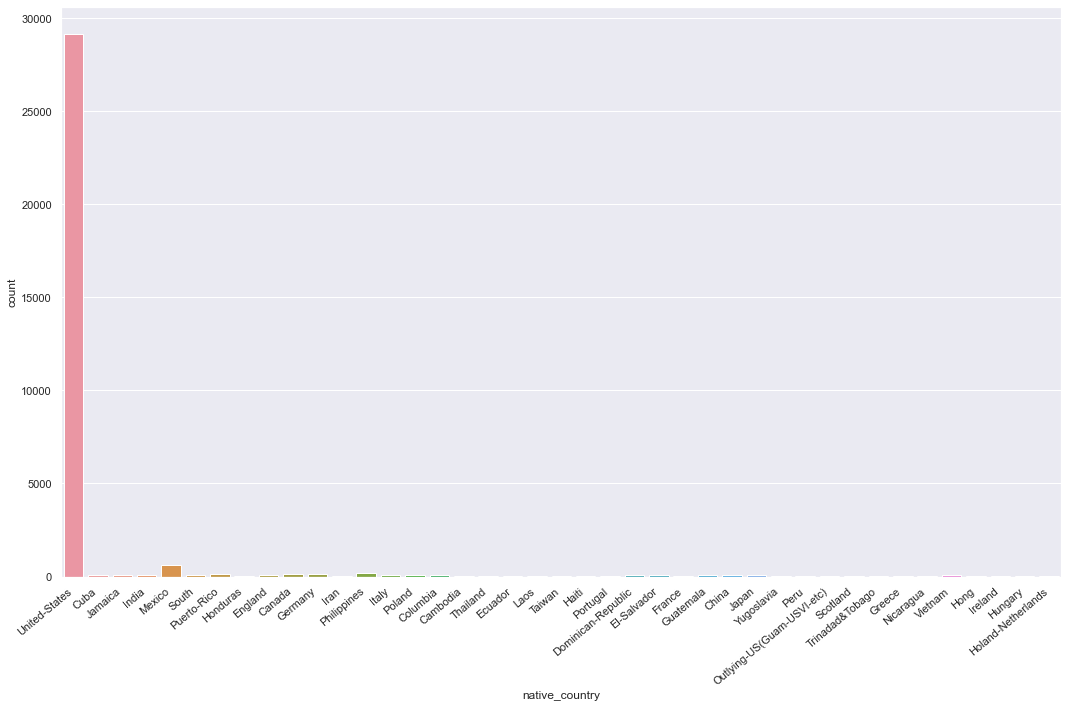

In [16]:
#Plot of Country corresponding to income
# plt.bar(count.index, count.values)
# plt.xlabel('Countries')
# plt.ylabel('Count')
# plt.title('Count from each Country')
plt.figure(figsize=(15,10))
ax = sns.countplot(x = 'native_country', data = data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

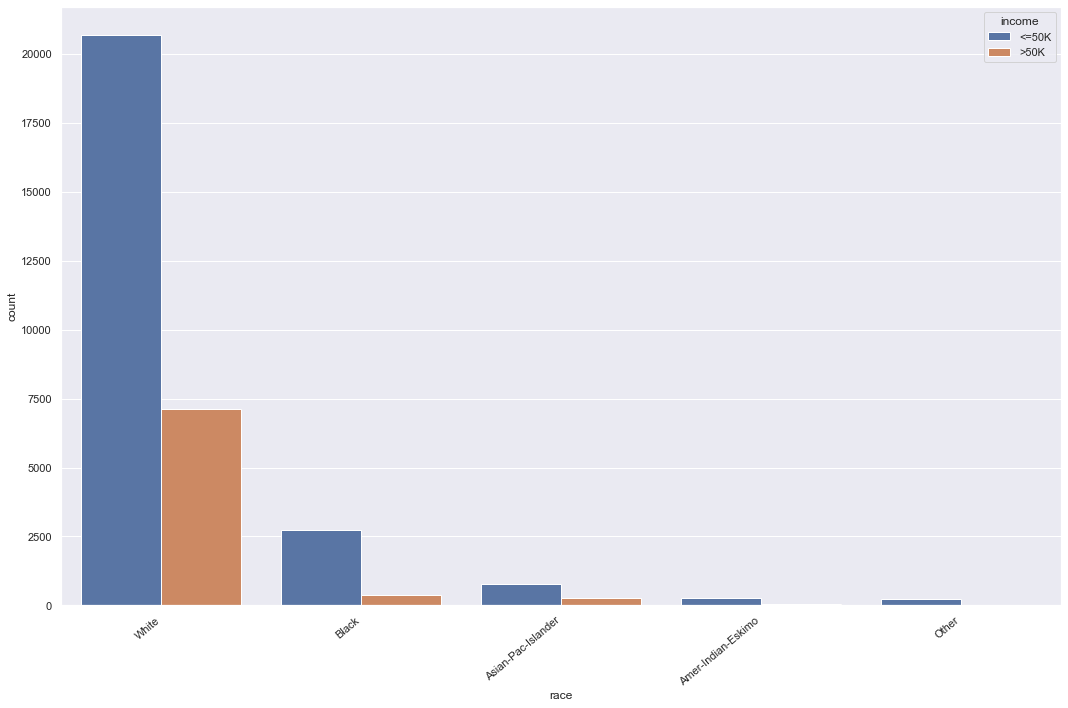

In [17]:
# visualize race
plt.figure(figsize=(15,10))
ax = sns.countplot(x = 'race', hue = 'income', data = data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

# preprocess data

In [18]:
print(data.shape)
print(data.capital_gain.unique().shape)
data.capital_loss.unique().shape

(32537, 15)
(119,)


(92,)

In [19]:
# dropping unimportant columns
# The ‘fnlwgt’ variable (stands for final weight) is removed as it has no predictive power since it is a feature aimed to allocate similar weights to people with similar demographic characteristics. 
# capital gain and capital loss are mostly 0
# education can be described by education-num 
data.drop(['fnlwgt', 'capital_gain', 'capital_loss', 'education'], axis=1, inplace=True)

## approach 1 with dropping rows with any na in it

In [20]:
# drop Na 
data_dropped = data.dropna(how='any')
# reset index after dropping rows
data_dropped = data_dropped.reset_index(drop=True)
print(data_dropped.isna().sum())
print(data_dropped.shape)

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
hours_per_week    0
native_country    0
income            0
dtype: int64
(30139, 11)


## approach 2 with replacing na values with mode

In [21]:
data.isnull().sum(axis = 0)

age                  0
workclass         1836
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
hours_per_week       0
native_country     582
income               0
dtype: int64

In [22]:
print(data['occupation'].describe())
data['occupation'] = data['occupation'].fillna('Prof-specialty')

count              30694
unique                14
top       Prof-specialty
freq                4136
Name: occupation, dtype: object


In [23]:
print(data['workclass'].describe())
data['workclass'] = data['workclass'].fillna('Private')

count       30701
unique          8
top       Private
freq        22673
Name: workclass, dtype: object


In [24]:
print(data['native_country'].describe())
data['native_country'] = data['native_country'].fillna('United-States')

count             31955
unique               41
top       United-States
freq              29153
Name: native_country, dtype: object


In [25]:
data.isna().sum()
print(data.shape)

(32537, 11)


## encoding approach 1

In [26]:
# encoding
# 1 = >50K; 0 = <=50K 
encoder_income = LabelEncoder()
data_dropped['income'] = encoder_income.fit_transform(data_dropped['income'])
encoder_worklass = LabelEncoder()
data_dropped['workclass'] = encoder_worklass.fit_transform(data_dropped['workclass'])
encoder_occupation = LabelEncoder()
data_dropped['occupation'] = encoder_occupation.fit_transform(data_dropped['occupation'])
encoder_relationship = LabelEncoder()
data_dropped['relationship'] = encoder_relationship.fit_transform(data_dropped['relationship'])
encoder_race = LabelEncoder()
data_dropped['race'] = encoder_race.fit_transform(data_dropped['race'])
encoder_sex = LabelEncoder()
data_dropped['sex'] = encoder_sex.fit_transform(data_dropped['sex'])
encoder_nativecountry  = LabelEncoder()
data_dropped['native_country'] = encoder_nativecountry.fit_transform(data_dropped['native_country'])
encoder_maritalstatus  = LabelEncoder()
data_dropped['marital_status'] = encoder_maritalstatus.fit_transform(data_dropped['marital_status'])
data_dropped.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
0,39,5,13,4,0,1,4,1,40,38,0
1,50,4,13,2,3,0,4,1,13,38,0
2,38,2,9,0,5,1,4,1,40,38,0
3,53,2,7,2,5,0,2,1,40,38,0
4,28,2,13,2,9,5,2,0,40,4,0


In [27]:
#Splitting the data set into features and outcome
X_dropped = data_dropped.drop(['income'], axis=1)
Y_dropped = data_dropped['income']
print(Y_dropped)
X_dropped.head()

0        0
1        0
2        0
3        0
4        0
        ..
30134    0
30135    1
30136    0
30137    0
30138    1
Name: income, Length: 30139, dtype: int32


,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country
0,39,5,13,4,0,1,4,1,40,38
1,50,4,13,2,3,0,4,1,13,38
2,38,2,9,0,5,1,4,1,40,38
3,53,2,7,2,5,0,2,1,40,38
4,28,2,13,2,9,5,2,0,40,4


## encoding approach 2

In [28]:
# encoding
# 1 = >50K; 0 = <=50K 
encoder_income = LabelEncoder()
data['income'] = encoder_income.fit_transform(data['income'])
encoder_worklass = LabelEncoder()
data['workclass'] = encoder_worklass.fit_transform(data['workclass'])
encoder_occupation = LabelEncoder()
data['occupation'] = encoder_occupation.fit_transform(data['occupation'])
encoder_relationship = LabelEncoder()
data['relationship'] = encoder_relationship.fit_transform(data['relationship'])
encoder_race = LabelEncoder()
data['race'] = encoder_race.fit_transform(data['race'])
encoder_sex = LabelEncoder()
data['sex'] = encoder_sex.fit_transform(data['sex'])
encoder_nativecountry  = LabelEncoder()
data['native_country'] = encoder_nativecountry.fit_transform(data['native_country'])
encoder_maritalstatus  = LabelEncoder()
data['marital_status'] = encoder_maritalstatus.fit_transform(data['marital_status'])
data.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
0,39,6,13,4,0,1,4,1,40,38,0
1,50,5,13,2,3,0,4,1,13,38,0
2,38,3,9,0,5,1,4,1,40,38,0
3,53,3,7,2,5,0,2,1,40,38,0
4,28,3,13,2,9,5,2,0,40,4,0


In [29]:
#Splitting the data set into features and outcome
X = data.drop(['income'], axis=1)
Y = data['income']
print(Y)
X.head()

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 32537, dtype: int32


,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country
0,39,6,13,4,0,1,4,1,40,38
1,50,5,13,2,3,0,4,1,13,38
2,38,3,9,0,5,1,4,1,40,38
3,53,3,7,2,5,0,2,1,40,38
4,28,3,13,2,9,5,2,0,40,4


# train data 

In [30]:
# define k-fold properties
# @Tim welches n_splits ist sinnvoll?
kf = KFold(n_splits=5, shuffle=True)

## approach 1

In [31]:
# define arrays to save the accuracy of every step of k-fold cross validation
accuracy_kNeighbor_1 = []
accuracy_decisionTree_1 = []
accuracy_randomForest_1 = []
accuracy_logisticRegression_1 = []
accuracy_neuronalNet_1 = []

In [32]:
X_dropped = X_dropped.to_numpy()
Y_dropped = Y_dropped.to_numpy().reshape(-1)

In [33]:
for train_index, test_index in kf.split(X_dropped):
    
        X_train, X_test = X_dropped[train_index], X_dropped[test_index]
        Y_train, Y_test = Y_dropped[train_index], Y_dropped[test_index]
        
    #KNeighbor
        kNeighbor = KNeighborsClassifier(n_neighbors=5)
        #train random forest only on training data
        kNeighbor = kNeighbor.fit(X_train, Y_train)
        #test random forest with test data
        kNeighbor_pred = kNeighbor.predict(X_test)
        kNeighbor_accuracy = accuracy_score(Y_test, kNeighbor_pred)
        print(f'KNeighbor: {kNeighbor_accuracy}')
        accuracy_kNeighbor_1.append(kNeighbor_accuracy)
        
    #Decision Tree
        decisionTree = DecisionTreeClassifier(random_state=0, criterion = 'entropy')
        #train decision tree only on training data
        decisionTree = decisionTree.fit(X_train, Y_train)
        #test decision tree with test data
        decisionTree_pred = decisionTree.predict(X_test)
        decisionTree_accuracy = accuracy_score(Y_test, decisionTree_pred)
        print(f'Decision Tree: {decisionTree_accuracy}')
        accuracy_decisionTree_1.append(decisionTree_accuracy)
        
    #Random Forest
        randomForest = RandomForestClassifier(max_depth=2, random_state=0)
        #train random forest only on training data
        randomForest = randomForest.fit(X_train, Y_train)
        #test random forest with test data
        randomForest_pred = randomForest.predict(X_test)
        randomForest_accuracy = accuracy_score(Y_test, randomForest_pred)
        print(f'Random Forest: {randomForest_accuracy}')
        accuracy_randomForest_1.append(randomForest_accuracy)
        
    #Logistic Regression
        logisticRegression = LogisticRegression(random_state=0, max_iter=500)
        #train logistic regression only on training data
        logisticRegression = logisticRegression.fit(X_train, Y_train)
        #test random forest with test data
        logisticRegression_pred = logisticRegression.predict(X_test)
        logisticRegression_accuracy = accuracy_score(Y_test, logisticRegression_pred)
        print(f'Logistic Regression: {logisticRegression_accuracy}')
        accuracy_logisticRegression_1.append(logisticRegression_accuracy)
        
    #Neuronal Net
        #@Tim welche max_iter sinnvoll? --> dauert so sehr lange schlimm?
        neuronalNet = MLPClassifier(random_state=1, max_iter=500).fit(X_train, Y_train)
        neuronalNet_pred = neuronalNet.predict(X_test)
        neuronalNet_accuracy = accuracy_score(Y_test, neuronalNet_pred)
        print(f'Neuronales Netz: {neuronalNet_accuracy}')
        accuracy_neuronalNet_1.append(neuronalNet_accuracy)
        print('\n')

KNeighbor: 0.7974452554744526
Decision Tree: 0.7901459854014599
Random Forest: 0.8083941605839416
Logistic Regression: 0.7976111479761114
Neuronales Netz: 0.8253151957531519


KNeighbor: 0.7974452554744526
Decision Tree: 0.7768745852687459
Random Forest: 0.8070670205706703
Logistic Regression: 0.7996018579960186
Neuronales Netz: 0.8153616456536165


KNeighbor: 0.8049104180491041
Decision Tree: 0.7820172528201725
Random Forest: 0.8115461181154612
Logistic Regression: 0.8085600530856005
Neuronales Netz: 0.8198407431984074


KNeighbor: 0.79628400796284
Decision Tree: 0.774386197743862
Random Forest: 0.8069011280690113
Logistic Regression: 0.8004313205043132
Neuronales Netz: 0.822992700729927


KNeighbor: 0.7940932470549196
Decision Tree: 0.7728554836568774
Random Forest: 0.8057076489132238
Logistic Regression: 0.79940268790443
Neuronales Netz: 0.8219678115148499




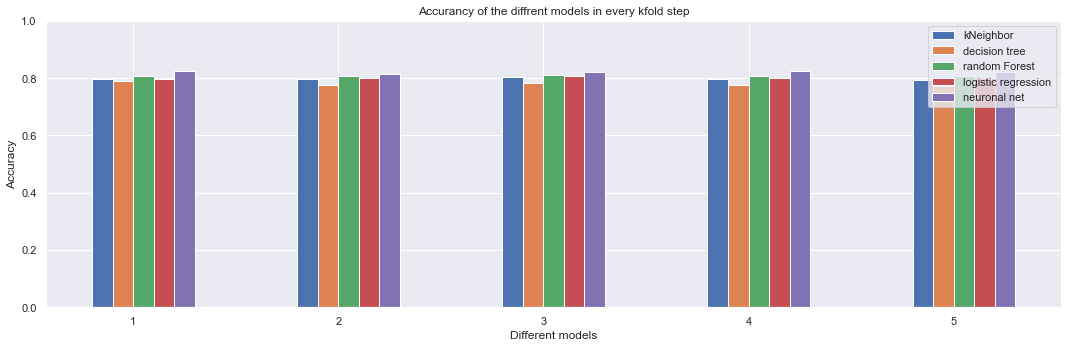

In [34]:
# print accuracy of each kfold step
plt.figure(figsize=(15,5))
ax = plt.subplot()
width = 0.1

X_label = ['1', '2', '3', '4', '5']
_X = np.arange(len(X_label))

ax.bar(_X, accuracy_kNeighbor_1, width, label='kNeighbor')
ax.bar(_X + width, accuracy_decisionTree_1, width, label='decision tree')
ax.bar(_X + (2*width), accuracy_randomForest_1, width, label='random Forest')
ax.bar(_X + (3*width), accuracy_logisticRegression_1, width, label='logistic regression')
ax.bar(_X + (4*width), accuracy_neuronalNet_1, width, label='neuronal net')

ax.set_ylabel('Accuracy')
ax.set_ylim(0,1)
ax.set_xticks(_X + width + width/2)
ax.set_xticklabels(X_label)
ax.set_xlabel('Different models')
ax.set_title('Accurancy of the diffrent models in every kfold step')
ax.legend()

plt.tight_layout()

plt.show()

In [35]:
# calculate average accuracy
avg_kNeigbor_1 = sum(accuracy_kNeighbor_1)/len(accuracy_kNeighbor_1)
avg_decisionTree_1 = sum(accuracy_decisionTree_1)/len(accuracy_decisionTree_1)
avg_randomForest_1 = sum(accuracy_randomForest_1)/len(accuracy_randomForest_1)
avg_logisticRegression_1 = sum(accuracy_logisticRegression_1)/len(accuracy_logisticRegression_1)
avg_neuronalNet_1 = sum(accuracy_neuronalNet_1)/len(accuracy_neuronalNet_1)

In [36]:
print(f'KNeighbor: {avg_kNeigbor_1}')
print(f'Decision Tree: {avg_decisionTree_1}')
print(f'Random Forest: {avg_randomForest_1}')
print(f'Logistic Regression: {avg_logisticRegression_1}')
print(f'Neuronal Net: {avg_neuronalNet_1}')

KNeighbor: 0.7980356368031538
Decision Tree: 0.7792559009782235
Random Forest: 0.8079232152504616
Logistic Regression: 0.8011214134932947
Neuronal Net: 0.8210956193699905


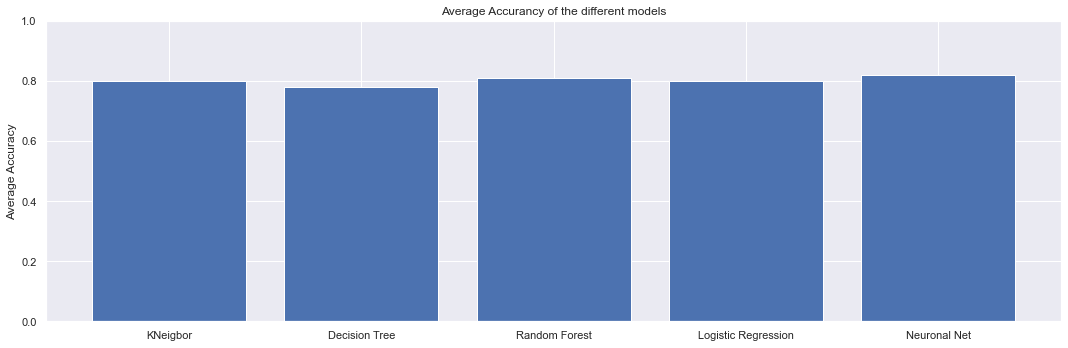

In [37]:
# print average accuracy of each model
plt.figure(figsize=(15,5))
ax = plt.subplot()
models = ['KNeigbor', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Neuronal Net']
avg_accuracies_1 = [avg_kNeigbor_1, avg_decisionTree_1, avg_randomForest_1, avg_logisticRegression_1, avg_neuronalNet_1] 

ax.bar(models, avg_accuracies_1)

ax.set_ylabel('Average Accuracy')
ax.set_ylim(0,1)
ax.set_title('Average Accurancy of the different models')

plt.tight_layout()
plt.show()

## aproach 2

In [38]:
# define arrays to save the accuracy of every step of k-fold cross validation
accuracy_kNeighbor_2 = []
accuracy_decisionTree_2 = []
accuracy_randomForest_2 = []
accuracy_logisticRegression_2 = []
accuracy_neuronalNet_2 = []

In [39]:
X = X.to_numpy()
Y = Y.to_numpy().reshape(-1)

In [40]:
for train_index, test_index in kf.split(X):
    
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
    #KNeighbor
        kNeighbor = KNeighborsClassifier(n_neighbors=5)
        #train random forest only on training data
        kNeighbor = kNeighbor.fit(X_train, Y_train)
        #test random forest with test data
        kNeighbor_pred = kNeighbor.predict(X_test)
        kNeighbor_accuracy = accuracy_score(Y_test, kNeighbor_pred)
        print(f'KNeighbor: {kNeighbor_accuracy}')
        accuracy_kNeighbor_2.append(kNeighbor_accuracy)
        
    #Decision Tree
        decisionTree = DecisionTreeClassifier(random_state=0, criterion = 'entropy')
        #train decision tree only on training data
        decisionTree = decisionTree.fit(X_train, Y_train)
        #test decision tree with test data
        decisionTree_pred = decisionTree.predict(X_test)
        decisionTree_accuracy = accuracy_score(Y_test, decisionTree_pred)
        print(f'Decision Tree: {decisionTree_accuracy}')
        accuracy_decisionTree_2.append(decisionTree_accuracy)
        
    #Random Forest
        randomForest = RandomForestClassifier(max_depth=2, random_state=0)
        #train random forest only on training data
        randomForest = randomForest.fit(X_train, Y_train)
        #test random forest with test data
        randomForest_pred = randomForest.predict(X_test)
        randomForest_accuracy = accuracy_score(Y_test, randomForest_pred)
        print(f'Random Forest: {randomForest_accuracy}')
        accuracy_randomForest_2.append(randomForest_accuracy)
        
    #Logistic Regression
        logisticRegression = LogisticRegression(random_state=0, max_iter=500)
        #train logistic regression only on training data
        logisticRegression = logisticRegression.fit(X_train, Y_train)
        #test random forest with test data
        logisticRegression_pred = logisticRegression.predict(X_test)
        logisticRegression_accuracy = accuracy_score(Y_test, logisticRegression_pred)
        print(f'Logistic Regression: {logisticRegression_accuracy}')
        accuracy_logisticRegression_2.append(logisticRegression_accuracy)
        
    #Neuronal Net
        #@Tim welche max_iter sinnvoll? --> dauert so sehr lange schlimm?
        neuronalNet = MLPClassifier(random_state=1, max_iter=500).fit(X_train, Y_train)
        neuronalNet_pred = neuronalNet.predict(X_test)
        neuronalNet_accuracy = accuracy_score(Y_test, neuronalNet_pred)
        print(f'Neuronales Netz: {neuronalNet_accuracy}')
        accuracy_neuronalNet_2.append(neuronalNet_accuracy)
        print('\n')

KNeighbor: 0.7996312231100184
Decision Tree: 0.7845728334357713
Random Forest: 0.8090043023970498
Logistic Regression: 0.8063921327596804
Neuronales Netz: 0.8271358328211432


KNeighbor: 0.7942532267977873
Decision Tree: 0.7745851259987707
Random Forest: 0.7859557467732022
Logistic Regression: 0.800860479409957
Neuronales Netz: 0.7965580823601721


KNeighbor: 0.8075918241893346
Decision Tree: 0.7869986168741355
Random Forest: 0.8103580759182419
Logistic Regression: 0.8069771015829107
Neuronales Netz: 0.8321807284462887


KNeighbor: 0.797448901183341
Decision Tree: 0.7713231904103274
Random Forest: 0.8143537728599969
Logistic Regression: 0.8102043952666359
Neuronales Netz: 0.8251114184724143


KNeighbor: 0.8051329337636391
Decision Tree: 0.7837713231904103
Random Forest: 0.7979099431381589
Logistic Regression: 0.8069771015829107
Neuronales Netz: 0.8315660058398647




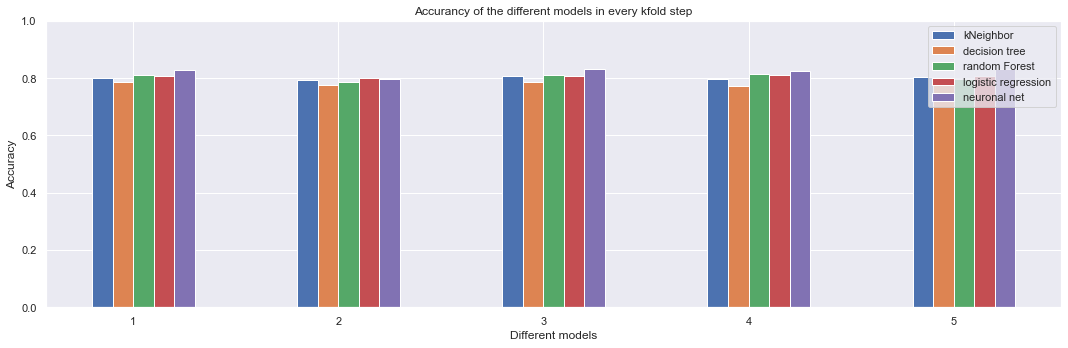

In [41]:
# print accuracy of each kfold step
plt.figure(figsize=(15,5))
ax = plt.subplot()
width = 0.1

X_label = ['1', '2', '3', '4', '5']
_X = np.arange(len(X_label))

ax.bar(_X, accuracy_kNeighbor_2, width, label='kNeighbor')
ax.bar(_X + width, accuracy_decisionTree_2, width, label='decision tree')
ax.bar(_X + (2*width), accuracy_randomForest_2, width, label='random Forest')
ax.bar(_X + (3*width), accuracy_logisticRegression_2, width, label='logistic regression')
ax.bar(_X + (4*width), accuracy_neuronalNet_2, width, label='neuronal net')

ax.set_ylabel('Accuracy')
ax.set_ylim(0,1)
ax.set_xticks(_X + width + width/2)
ax.set_xticklabels(X_label)
ax.set_xlabel('Different models')
ax.set_title('Accurancy of the different models in every kfold step')
ax.legend()

plt.tight_layout()

plt.show()

In [42]:
# calculate average accuracy
avg_kNeigbor_2 = sum(accuracy_kNeighbor_2)/len(accuracy_kNeighbor_2)
avg_decisionTree_2 = sum(accuracy_decisionTree_2)/len(accuracy_decisionTree_2)
avg_randomForest_2 = sum(accuracy_randomForest_2)/len(accuracy_randomForest_2)
avg_logisticRegression_2 = sum(accuracy_logisticRegression_2)/len(accuracy_logisticRegression_2)
avg_neuronalNet_2 = sum(accuracy_neuronalNet_2)/len(accuracy_neuronalNet_2)

In [43]:
print(f'KNeighbor: {avg_kNeigbor_2}')
print(f'Decision Tree: {avg_decisionTree_2}')
print(f'Random Forest: {avg_randomForest_2}')
print(f'Logistic Regression: {avg_logisticRegression_2}')
print(f'Neuronal Net: {avg_neuronalNet_2}')

KNeighbor: 0.800811621808824
Decision Tree: 0.780250217981883
Random Forest: 0.80351636821733
Logistic Regression: 0.8062822421204189
Neuronal Net: 0.8225104135879766


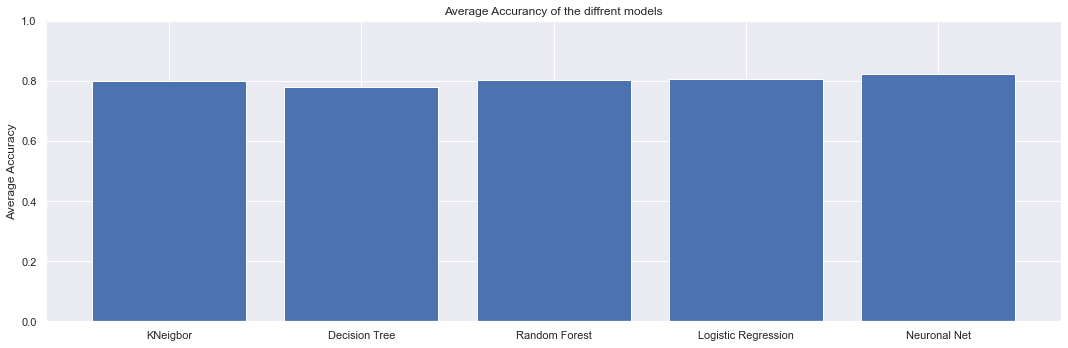

In [44]:
# print average accuracy of each model
plt.figure(figsize=(15,5))
ax = plt.subplot()
models = ['KNeigbor', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Neuronal Net']
avg_accuracies_2 = [avg_kNeigbor_2, avg_decisionTree_2, avg_randomForest_2, avg_logisticRegression_2, avg_neuronalNet_2] 

ax.bar(models, avg_accuracies_2)

ax.set_ylabel('Average Accuracy')
ax.set_ylim(0,1)
ax.set_title('Average Accurancy of the diffrent models')

plt.tight_layout()
plt.show()

## compare approaches

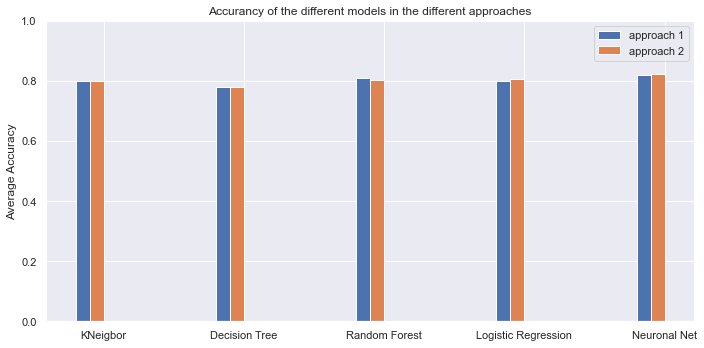

In [45]:
# print average accuracy of each approach
plt.figure(figsize=(10,5))
ax = plt.subplot()
width = 0.1

X_label = ['KNeigbor', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Neuronal Net']
_X = np.arange(len(X_label))

ax.bar(_X, avg_accuracies_1, width, label='approach 1')
ax.bar(_X + width, avg_accuracies_2, width, label='approach 2')

ax.set_ylabel('Average Accuracy')
ax.set_ylim(0,1)
ax.set_xticks(_X + width + width/2)
ax.set_xticklabels(X_label)
ax.set_title('Accurancy of the different models in the different approaches')
ax.legend()

plt.tight_layout()

plt.show()

# evaluation

## approach 1